In [ ]:
!pip install git+https://github.com/passerim/peer-reviewed-flower.git

In [1]:
# import prflwr to use it in the notebook
import os; os.chdir("../.."); import prflwr; os.chdir("experiments/fedlsbt")

In [2]:
import json
from copy import deepcopy as cp
from typing import Any, Dict, List, Optional, Tuple, Union

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
from flwr.common import (
    Code,
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    Status,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server import ClientManager, ServerConfig, SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.tree._tree import Tree

from prflwr.peer_review import (
    PeerReviewClient,
    PeerReviewServer,
    ReviewIns,
    ReviewRes,
    TrainIns,
    TrainRes,
)
from prflwr.peer_review.strategy import (
    AggregateReviewException,
    AggregateTrainException,
    PeerReviewedFedAvg,
)
from prflwr.simulation import start_simulation

In [ ]:
# Training configurations
NUM_CLIENTS = 30
FRACTION_FIT = 1 / 3
FRACTION_REVIEW = 1 / 3
FRACTION_EVAL = 0  # No federated evaluation
NUM_ROUNDS = 50

# Model hyperparameter
MAX_LEAVES = 8

# Useful constants
OK_STATUS = Status(Code.OK, "")

In [4]:
# Load data
DATA_HOME = "./data"
data_x, data_y = fetch_california_housing(
    data_home=DATA_HOME, return_X_y=True, as_frame=True
)
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, shuffle=True
)

# Turn the regression problem into a classification one
x_train = x_train[(y_train < 5)]
y_train = y_train[(y_train < 5)]
threshold = y_train.median()
y_train = y_train > threshold
y_test = y_test > threshold

In [5]:
x_train.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
1995,1.4427,43.0,4.520513,0.997436,1623.0,4.161538,36.72,-119.77
1686,5.1178,28.0,5.839542,0.942693,947.0,2.713467,37.98,-122.26
270,3.8750,33.0,3.021277,0.659574,575.0,12.234043,37.78,-122.18
18733,2.1250,28.0,5.007018,1.066667,692.0,2.428070,40.53,-122.39
12894,4.6000,27.0,6.304348,0.972332,610.0,2.411067,38.65,-121.34
...,...,...,...,...,...,...,...,...
19998,2.0313,18.0,5.440000,1.093333,253.0,3.373333,36.09,-119.45
10889,4.5757,15.0,3.610410,1.082019,982.0,1.548896,33.70,-117.90
5042,1.7067,49.0,4.304878,1.015244,901.0,2.746951,33.98,-118.32
693,2.1552,23.0,3.812641,1.040632,828.0,1.869074,37.70,-122.11


In [19]:
# Fit a centralized GBT model for classification
clf = GradientBoostingClassifier(
    loss="log_loss",
    n_estimators=int(NUM_ROUNDS * (NUM_CLIENTS * FRACTION_FIT)),
    subsample=1 / NUM_CLIENTS,
    init="zero",
    random_state=0,
)
clf.fit(x_train, y_train)

# Print performance metrics measured on the test data
print("accuracy:", np.mean(clf.predict(x_test) == y_test))
print("log_loss:", log_loss(y_test, clf.predict_proba(x_test)))

accuracy: 0.8292151162790697
log_loss: 1.9835831486494708


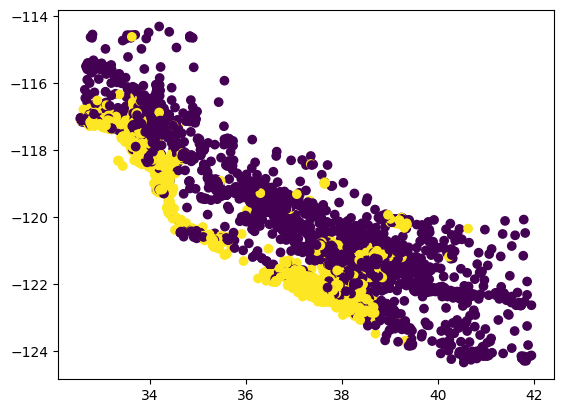

In [9]:
# Inspect the distribution of the latitude and longitude of the samples
# There are natural clusters of samples of the same class
# Latitude and lognitude features will be used to split the samples in a non-iid way
geo_data = x_train[["Latitude", "Longitude"]].to_numpy()
plt.scatter(*geo_data.transpose(), c=y_train)
plt.show()

In [10]:
# Cluster samples based on latitude and longitude
kmeans = KMeans(NUM_CLIENTS)
train_clusters = kmeans.fit_predict(geo_data)
test_clusters = kmeans.predict(x_test[["Latitude", "Longitude"]].to_numpy())
plt.scatter(*geo_data.transpose(), c=train_clusters)
plt.show()

In [13]:
# Test performances of a random classifier on the test data
print("accuracy:", np.mean(float(y_train.mode()) == y_test))
print("log_loss:", log_loss(y_test, [float(y_train.mode()),] * len(y_test)))

accuracy: 0.47238372093023256
log_loss: 18.223220685105492


In [14]:
# Simulation of the FedLSBT algorithm useful for experimental purposes
DEBUG = True


def fit(
    X,
    y,
    *,
    base_estimator=ExtraTreeRegressor,
    n_estimators=50,
    fraction_fit=1.0,
    fraction_review=1.0,
):
    fit_clients = max(0, min(kmeans.n_clusters, int(fraction_fit * kmeans.n_clusters)))
    review_clients = max(
        0, min(kmeans.n_clusters, int(fraction_review * kmeans.n_clusters))
    )
    if DEBUG:
        print(f"[DEBUG] fit_clients: {fit_clients}, review_clients: {review_clients}")
    model = {"estimators": [], "gammas": []}
    losses = []
    y_predf = 0
    probabilities = 0.5
    for _ in range(n_estimators):
        train_subset = np.random.choice(np.unique(kmeans.labels_), fit_clients, False)
        if DEBUG:
            print(f"[DEBUG] random clients train subset: {train_subset}")
        candidates = {"trees": [], "gamma_numerator": [], "gamma_denominator": []}
        ri = y - probabilities
        # -#-#-#-#-#-#-#-#- Client Training -#-#-#-#-#-#-#-#-#-#-#
        for i in train_subset:
            tree = base_estimator(max_leaf_nodes=MAX_LEAVES, random_state=i**2)
            tree.fit(X.iloc[train_clusters == i], ri.iloc[train_clusters == i])
            candidates["trees"].append(tree)
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        # -#-#-#-#-#-#-#-#- Client Review -#-#-#-#-#-#-#-#-#-#-#-#
        for n, i in enumerate(train_subset):
            h_k = [
                tree.predict(X.iloc[train_clusters == i])
                # if n != m
                # else np.zeros(len(X.iloc[train_clusters == i]))
                for m, tree in enumerate(candidates["trees"])
            ]
            h_k = np.stack(h_k, axis=1).T
            numerator_k = h_k @ ri.iloc[train_clusters == i]
            denominator_k = h_k @ h_k.T
            candidates["gamma_numerator"].append(numerator_k)
            candidates["gamma_denominator"].append(denominator_k)
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        # -#-#-#-#-#-#-#-#- Server Aggregate -#-#-#-#-#-#-#-#-#-#-
        gamma_numerator = sum(candidates["gamma_numerator"])
        gamma_denominator = sum(candidates["gamma_denominator"])
        gamma = np.linalg.pinv(gamma_denominator) @ gamma_numerator
        gamma = gamma / (len(gamma))
        for i, tree in enumerate(candidates["trees"]):
            y_predf = y_predf + gamma[i] * tree.predict(X)
            model["estimators"].append(tree)
            model["gammas"].append(gamma[i])
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        probabilities = 1 / (1 + np.exp(-y_predf))
        losses.append(log_loss(y, probabilities))
    return model, losses


def predict(X, model):
    y_pred = np.zeros(X.shape[0])
    for estimator, gamma in zip(model["estimators"], model["gammas"]):
        y_pred = y_pred + gamma * estimator.predict(X)
    return 1 / (1 + np.exp(-y_pred))


def predict_proba(X, model):
    return np.round(predict_proba(X, model))

In [15]:
# Fit the FedLSBT model
np.random.seed(0)
model, losses = fit(
    x_train,
    y_train,
    base_estimator=ExtraTreeRegressor,
    n_estimators=50,
    fraction_fit=1 / 3,
    fraction_review=1 / 3,
)

[DEBUG] fit_clients: 10, review_clients: 10
[DEBUG] random clients train subset: [ 2 28 13 10 26 24 27 11 17 22]
[DEBUG] random clients train subset: [ 5 16 20  6 13  8 11 12  2 25]
[DEBUG] random clients train subset: [24 27 21 25 14 12 19 23 29 16]
[DEBUG] random clients train subset: [25  6 10 22 17  7 24  2 18 11]
[DEBUG] random clients train subset: [ 8 23 27  5 24 15  6 12 28 29]
[DEBUG] random clients train subset: [ 5  7  9  1 25 27  4 23 29 15]
[DEBUG] random clients train subset: [15 23 28 10 12  2 18 19 17  7]
[DEBUG] random clients train subset: [27 11 19 26  9 16 21  2  4  8]
[DEBUG] random clients train subset: [ 4 12 11  0  1  6  5  8 26 15]
[DEBUG] random clients train subset: [ 9 21 18  6 22 12 10  7 15 29]
[DEBUG] random clients train subset: [ 9  0 10  4 16 21 23  8 13  3]
[DEBUG] random clients train subset: [ 2  5 29  6 25 15 23 12 20 26]
[DEBUG] random clients train subset: [28 16  9  2 15  6 25 23  1 12]
[DEBUG] random clients train subset: [17 22  4  2 14 24  0 

In [16]:
# Measure the performance of the FedLSBT model on the test data
print("accuracy:", np.mean(np.round(predict(x_test, model)) == y_test))
print("log_loss:", log_loss(y_test, predict(x_test, model)))

accuracy: 0.8035368217054264
log_loss: 0.5092202668159757


0.018386833503809777

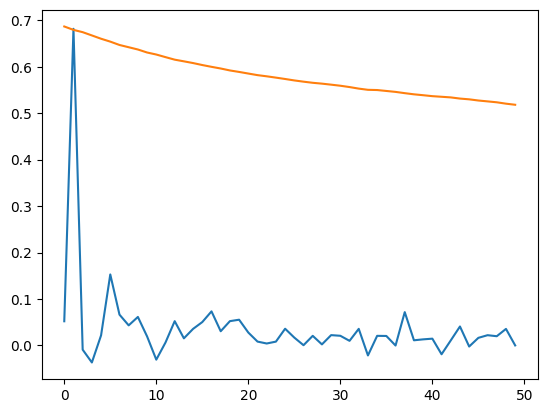

In [17]:
# Plots about the coefficients and losses during training
plt.plot(model["gammas"][::10])
plt.plot(losses)
sum(model["gammas"]) / len(model["gammas"])

In [104]:
# Implementation of the FedLSBT model serialization


def tree_to_state_dict(tree: Tree) -> Dict[str, Any]:
    serialized_tree = tree.__getstate__()
    dtypes = serialized_tree["nodes"].dtype
    serialized_tree["nodes_dtype"] = [dtypes[i].str for i in range(0, len(dtypes))]
    serialized_tree["nodes"] = serialized_tree["nodes"].tolist()
    serialized_tree["values"] = serialized_tree["values"].tolist()
    return serialized_tree


def decision_tree_regressor_to_state_dict(
    model: DecisionTreeRegressor,
) -> Dict[str, Any]:
    serialized_model = model.__getstate__()
    tree = tree_to_state_dict(model.tree_)
    serialized_model["feature_names_in_"] = model.feature_names_in_.tolist()
    serialized_model["tree_"] = tree
    return serialized_model


def serialize_decision_tree_regressor(model: DecisionTreeRegressor) -> bytes:
    model_state_dict = decision_tree_regressor_to_state_dict(model)
    json_formatted = json.dumps(model_state_dict)
    return bytes(json_formatted, "utf-8")


def state_dict_to_tree(
    tree_dict: Dict[str, Any], n_features: int, n_classes: int, n_outputs: int
):
    tree_dict["nodes"] = [tuple(lst) for lst in tree_dict["nodes"]]
    names = [
        "left_child",
        "right_child",
        "feature",
        "threshold",
        "impurity",
        "n_node_samples",
        "weighted_n_node_samples",
    ]
    tree_dict["nodes"] = np.array(
        tree_dict["nodes"],
        dtype=np.dtype({"names": names, "formats": tree_dict["nodes_dtype"]}),
    )
    tree_dict["values"] = np.array(tree_dict["values"])
    tree = Tree(n_features, np.array([n_classes], dtype=np.intp), n_outputs)
    tree.__setstate__(tree_dict)
    return tree


def state_dict_to_decision_tree_regressor(model_dict: Dict[str, Any]):
    deserialized_decision_tree = DecisionTreeRegressor()
    for key, value in iter(model_dict.items()):
        if key == "feature_names_in_":
            setattr(deserialized_decision_tree, key, np.asarray(value))
        elif key != "tree_":
            setattr(deserialized_decision_tree, key, value)
    tree = state_dict_to_tree(
        model_dict["tree_"], model_dict["n_features_in_"], 1, model_dict["n_outputs_"]
    )
    deserialized_decision_tree.tree_ = tree
    return deserialized_decision_tree


def deserialize_decision_tree_regressor(
    model_serialized: bytes,
) -> DecisionTreeRegressor:
    json_formatted = str(model_serialized, "utf-8")
    model_state_dict = json.loads(json_formatted)
    return state_dict_to_decision_tree_regressor(model_state_dict)


class FederatedGradientBoostingClassifier:
    def __init__(self):
        self.estimators_ = []
        self.gammas_ = []

    def predict_proba(self, x):
        y_pred = np.zeros(x.shape[0])
        for estimator, gamma in zip(self.estimators_, self.gammas_):
            y_pred = y_pred + gamma * estimator.predict(x)
        return 1 / (1 + np.exp(-y_pred))

    def predict(self, x):
        return np.round(self.predict_proba(x))

    def add_estimator(self, estimator, gamma):
        if not self.estimators_:
            self.max_features_ = estimator.max_features_
            self.n_features_in_ = estimator.n_features_in_
        for attr in ["max_features_", "n_features_in_"]:
            if getattr(self, attr) != getattr(estimator, attr):
                return
        self.estimators_.append(estimator)
        self.gammas_.append(gamma)


def gradient_boosting_to_state_dict(
    model: FederatedGradientBoostingClassifier,
) -> Dict[str, Any]:
    serialized_model = {
        "estimators_": [],
        "gammas_": model.gammas_,
    }
    if getattr(model, "max_features_", None):
        serialized_model["max_features_"] = model.max_features_
    if getattr(model, "n_features_in_", None):
        serialized_model["n_features_in_"] = model.n_features_in_
    for tree in model.estimators_:
        serialized_model["estimators_"].append(
            decision_tree_regressor_to_state_dict(tree)
        )
    return serialized_model


def state_dict_to_gradient_boosting(
    model_dict: Dict[str, Any]
) -> FederatedGradientBoostingClassifier:
    model = FederatedGradientBoostingClassifier()
    model.estimators_ = [
        state_dict_to_decision_tree_regressor(tree)
        for tree in model_dict["estimators_"]
    ]
    model.gammas_ = model_dict["gammas_"]
    if model_dict.get("max_features_", False):
        model.max_features_ = model_dict["max_features_"]
    if model_dict.get("max_features_", False):
        model.n_features_in_ = model_dict["n_features_in_"]
    return model


def serialize_gradient_boosting_classifier(
    model: FederatedGradientBoostingClassifier,
) -> bytes:
    json_formatted = json.dumps(gradient_boosting_to_state_dict(model))
    return bytes(json_formatted, "utf-8")


def deserialize_gradient_boosting_classifier(
    model_serialized: bytes,
) -> FederatedGradientBoostingClassifier:
    json_formatted = str(model_serialized, "utf-8")
    model_dict = json.loads(json_formatted)
    return state_dict_to_gradient_boosting(model_dict)


def serialize_global_model_and_candidates(
    model: Union[FederatedGradientBoostingClassifier, bytes],
    candidates: Union[List[DecisionTreeRegressor], bytes],
) -> bytes:
    if isinstance(model, bytes):
        model = deserialize_gradient_boosting_classifier(model)
    if isinstance(candidates[0], bytes):
        candidates = [deserialize_decision_tree_regressor(tree) for tree in candidates]
    serialized_models = dict(
        global_model=gradient_boosting_to_state_dict(model),
        candidate_models=[
            decision_tree_regressor_to_state_dict(tree) for tree in candidates
        ],
    )
    json_serialized = json.dumps(serialized_models)
    return bytes(json_serialized, "utf-8")

In [105]:
# FedLSBT client implementation with PeerReview-Flower


class FedLSBTClient(PeerReviewClient):
    def __init__(
        self,
        cid: int,
        trainset: Tuple[np.ndarray, np.array],
        testset: Tuple[np.ndarray, np.array],
    ):
        self.cid = cid
        self.trainset = trainset
        self.testset = testset

    def train(self, ins: TrainIns) -> TrainRes:
        parameters = ins.parameters
        model = deserialize_gradient_boosting_classifier(parameters.tensors)
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        ri = self.trainset[1] - model.predict_proba(self.trainset[0])
        tree = ExtraTreeRegressor(
            max_leaf_nodes=MAX_LEAVES,
            random_state=self.cid**2,
        )
        tree.fit(self.trainset[0], ri)
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        res = TrainRes(
            OK_STATUS,
            Parameters(serialize_decision_tree_regressor(tree), ""),
            len(self.trainset[1]),
            {},
        )
        return res

    def review(self, ins: ReviewIns) -> ReviewRes:
        parameters = ins.parameters
        state_dicts = json.loads(str(parameters.tensors, "utf-8"))
        model = state_dict_to_gradient_boosting(state_dicts["global_model"])
        candidates = [
            state_dict_to_decision_tree_regressor(tree)
            for tree in state_dicts["candidate_models"]
        ]
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-##-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        res_model = self.trainset[1] - model.predict_proba(self.trainset[0])
        res_candidates = [tree.predict(self.trainset[0]) for tree in candidates]
        res_candidates = np.stack(res_candidates, axis=1).T
        numerator_k = res_candidates @ res_model
        denominator_k = res_candidates @ res_candidates.T
        # -#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-##-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#
        res = ReviewRes(
            OK_STATUS,
            ndarrays_to_parameters([numerator_k, denominator_k]),
            len(self.trainset[1]),
            {},
        )
        return res

    def evaluate(self, ins: EvaluateIns) -> EvaluateRes:
        parameters, config = ins.parameters, ins.config
        model = deserialize_gradient_boosting_classifier(parameters.tensors)
        y_pred = model.predict(self.testset[0])
        loss = log_loss(self.testset[1], y_pred)
        return EvaluateRes(OK_STATUS, loss, len(self.testset[1]), {})

In [106]:
# FedLSBT strategy implementation with PeerReview-Flower


class FederatedGradientBoostingStrategy(PeerReviewedFedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def aggregate_train(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
        parameters: Optional[Parameters] = None,
    ) -> List[Tuple[Optional[Parameters], Dict[str, Scalar]]]:
        if not results:
            raise AggregateTrainException
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            raise AggregateTrainException

        # Save ClientProxies
        self.current_round_clients = [proxy for proxy, _ in results]

        # Collect results
        return [(fit_res.parameters, {}) for _, fit_res in results]

    def configure_review(
        self,
        server_round: int,
        review_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> List[Tuple[ClientProxy, FitIns]]:
        # Make instructions and configurations
        config = {}
        if self.on_fit_config_fn is not None:
            # Custom fit config function provided
            config = self.on_fit_config_fn(server_round)
        # Serialize current gloabal model and candidates
        serialized = serialize_global_model_and_candidates(
            parameters.tensors, [params.tensors for params in parameters_aggregated]
        )
        review_ins = ReviewIns(Parameters(serialized, ""), config)

        # Return client/config pairs
        return [(client, review_ins) for client in self.current_round_clients]

    def aggregate_review(
        self,
        server_round: int,
        review_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
        parameters: Parameters,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> List[Tuple[Optional[Parameters], Dict[str, Scalar]]]:
        if not results:
            raise AggregateReviewException
        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            raise AggregateReviewException
        # Compute gamma
        gamma_numerator = sum(
            [
                parameters_to_ndarrays(review_res.parameters)[0]
                for _, review_res in results
            ]
        )
        gamma_denominator = sum(
            [
                parameters_to_ndarrays(review_res.parameters)[1]
                for _, review_res in results
            ]
        )
        gamma = np.linalg.pinv(gamma_denominator) @ gamma_numerator
        gamma = gamma / (len(gamma))
        # Return candidates parameters along with gamma
        return [
            (params, gamma_i) for params, gamma_i in zip(parameters_aggregated, gamma)
        ]

    def aggregate_after_review(
        self,
        server_round: int,
        parameters: Parameters,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> Optional[Parameters]:
        # Update global model with candidated weighted by computed gamma
        model = deserialize_gradient_boosting_classifier(parameters.tensors)
        for params, gamma in zip(parameters_aggregated, metrics_aggregated):
            model.add_estimator(
                deserialize_decision_tree_regressor(params.tensors), gamma
            )
        # Return the new serialized global model
        return Parameters(serialize_gradient_boosting_classifier(model), "")

    def stop_review(
        self,
        server_round: int,
        review_round: int,
        parameters: Parameters,
        client_manager: ClientManager,
        parameters_aggregated: List[Optional[Parameters]],
        metrics_aggregated: List[Dict[str, Scalar]],
    ) -> bool:
        # Always stop the review process after the second review round
        return True if review_round == 2 else False

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        model = FederatedGradientBoostingClassifier()
        return Parameters(serialize_gradient_boosting_classifier(model), "")

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        eval_res = self.evaluate_fn(server_round, parameters, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res
        return loss, metrics

In [108]:
# Setup of the federated learning simulation using PeerReview-Flower sequential simulation


def client_fn(cid: str):
    cid = int(cid)
    trainset = (
        x_train.iloc[train_clusters == cid],
        y_train.iloc[train_clusters == cid],
    )
    testset = (x_test.iloc[test_clusters == cid], y_test.iloc[test_clusters == cid])
    return FedLSBTClient(cid, cp(trainset), cp(testset))


def evaluate_fn(
    server_round: int,
    parameters: Parameters,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    model = deserialize_gradient_boosting_classifier(parameters.tensors)
    y_pred = model.predict_proba(x_test)
    loss = log_loss(y_test, y_pred)
    return loss, {}


strategy = FederatedGradientBoostingStrategy(
    fraction_fit=FRACTION_FIT,
    fraction_review=FRACTION_REVIEW,
    fraction_evaluate=FRACTION_EVAL,
    min_fit_clients=int(NUM_CLIENTS * FRACTION_FIT),
    min_review_clients=int(NUM_CLIENTS * FRACTION_REVIEW),
    min_evaluate_clients=int(NUM_CLIENTS * FRACTION_EVAL),
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=evaluate_fn,
)
server = PeerReviewServer(strategy=strategy)

np.random.seed(0)
hist = start_simulation(
    num_clients=NUM_CLIENTS,
    client_fn=client_fn,
    server=server,
    config=ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
)

WARNING flower 2022-12-02 19:13:19,128 | app.py:165 | Both server and strategy were provided, ignoring strategy
INFO flower 2022-12-02 19:13:19,130 | app.py:142 | Starting Flower simulation, config: ServerConfig(num_rounds=50, round_timeout=None)
INFO flower 2022-12-02 19:13:24,620 | app.py:176 | Flower VCE: Ray initialized with resources: {'CPU': 8.0, 'object_store_memory': 1385409331.0, 'memory': 2770818663.0, 'node:192.168.178.22': 1.0}
INFO flower 2022-12-02 19:13:24,622 | server.py:114 | Initializing global parameters
INFO flower 2022-12-02 19:13:24,622 | server.py:391 | Using initial parameters provided by strategy
INFO flower 2022-12-02 19:13:24,623 | server.py:117 | Evaluating initial parameters
INFO flower 2022-12-02 19:13:24,629 | server.py:120 | initial parameters (loss, other metrics): 0.6931471805599452, {}
INFO flower 2022-12-02 19:13:24,630 | server.py:58 | FL starting
DEBUG flower 2022-12-02 19:13:24,631 | server.py:246 | train_round 1: strategy sampled 10 clients (out 

In [109]:
# Get trained FedLSBT model and test performances on test data
model = deserialize_gradient_boosting_classifier(server.parameters.tensors)
print(f"accuracy: {np.mean(model.predict(x_test) == y_test)}")
print(f"log_loss: {log_loss(y_test, model.predict_proba(x_test))}")

accuracy: 0.810077519379845
log_loss: 0.49275635780347965


0.01664246427312332

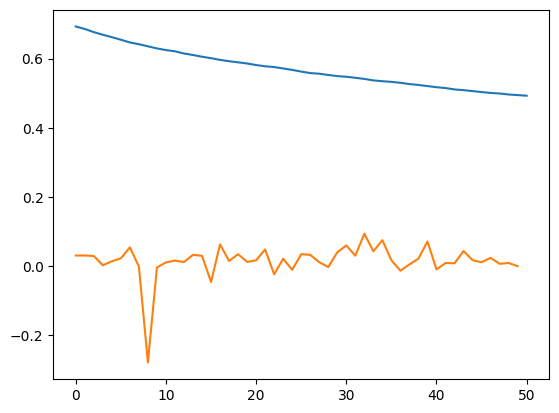

In [110]:
# Plot model losses during training and trees coefficients
plt.plot([l[1] for l in hist.losses_centralized])
plt.plot(model.gammas_[::10])
sum(model.gammas_) / len(model.gammas_)